In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import sys
import collections
%matplotlib inline

In [45]:
# constants
in_data_dir = "../data"
search_perfomance_dir = "search_performance"

until_data_path = os.path.join(in_data_dir, search_perfomance_dir)
until_data_path

'../data/search_performance'

In [46]:
# 読み込み対象としたいファイル名
target_file = "2020-02-13.csv"

In [133]:
# ==================================
#  Utils for Analyze
# ==================================

# google search console 検索パフォーマンスのデータの読み込み関数
def read_performance_csv(file_name):
    until_file_path = os.path.join(until_data_path, file_name)
    return pd.read_csv(until_file_path)

# 概要を表示
def display_describe(df):
    return df.describe()

# 何ページ目に表示されているかを算出
def calc_page_num(top_n, each_num=10):
    return math.floor(top_n / each_num) + 1

# %表示を小数点表示に変換
def per_to_float(per_str):
    return float(per_str[:-1]) / 100

## カラムの説明
- keyword -> 検索キーワード: 実際に検索に用いられている検索キーワード、もしくは組み合わせ
- click_num -> クリック数: 表示された回数の中で何度ページが開かれたか(クリックされたか)
- display_num -> 表示回数: 検索されたキーワードを元に何度も自身の投稿した記事が表示されたか(ヒットしたか)
- ctr -> CTR: クリック数 / 表示回数 によって算出される値。つまりは頻度
- top_n -> 掲載順位: 広告差し込みを除いて何番目に表示されているか

In [134]:
read_csv = read_performance_csv(target_file).rename(columns={
    "検索キーワード": "keyword",
    "クリック数": "click_num",
    "表示回数": "display_num",
    "CTR": "ctr",
    "掲載順位": "top_n"
})
read_csv

,keyword,click_num,display_num,ctr,top_n
0,janome mecab,38,215,17.67%,3.18
1,mecab janome,32,114,28.07%,2.99
2,janome mecab 違い,12,37,32.43%,2.16
3,elixir python,10,45,22.22%,4.13
4,mecab tokenizer,7,68,10.29%,4.79
5,elixir optionparser,6,18,33.33%,13.33
6,janome 形態素解析,4,85,4.71%,9.15
7,cloud functions デプロイ,4,67,5.97%,8.64
8,elixir cli,4,27,14.81%,4.56
9,python 形態素解析 比較,3,118,2.54%,7.50


In [ ]:
read_csv.to_

In [135]:
# 中央値や、平均値などを確認
display_describe(read_csv)

,click_num,display_num,top_n
count,569.000000,569.000000,569.000000
mean,0.314587,6.843585,48.686766
std,2.258275,19.082617,32.940964
min,0.000000,1.000000,2.000000
25%,0.000000,1.000000,21.500000
50%,0.000000,2.000000,43.000000
75%,0.000000,4.000000,73.860000
max,38.000000,215.000000,211.000000


## 結果の確認と考察
- 少なくとも検索結果として表示されれば3回に１度はクリックされている模様 -> 意外と多いと実感
- 掲載順位は大体が４ページ目ぐらい -> 何ぞやの調査で１ページ以降を閲覧する割合はかなり低かったのでこれは致命的
- 検索すれば２番目に表示される記事があることに驚きを隠せない
- 50%の時点で掲載順位の値が43(すなわち4ページ目)であるため、半数以上の記事は検索からの流入を期待出来ない

In [168]:
##　top_nの値から何ページ目に表示されているのかを算出してカラムに追加
add_page_num = read_csv.assign(
    page_num=lambda df: df.top_n.apply(lambda row: calc_page_num(row)),
    float_ctr=lambda df: df.ctr.apply(lambda row: per_to_float(row))
)

## ２番目に表示される記事が何なのかを確認 & １ページ目に表示されるkeywordの入力パターンを確認
display_on_one_page = add_page_num.sort_values("top_n")[add_page_num.page_num == 1]
display_on_one_page

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,keyword,click_num,display_num,ctr,top_n,page_num,float_ctr
18,mecab janome 比較,2,14,14.29%,2.00,1,0.1429
2,janome mecab 違い,12,37,32.43%,2.16,1,0.3243
1,mecab janome,32,114,28.07%,2.99,1,0.2807
31,elixir option parser,1,6,16.67%,3.00,1,0.1667
0,janome mecab,38,215,17.67%,3.18,1,0.1767
20,optionparser elixir,2,8,25%,3.38,1,0.2500
3,elixir python,10,45,22.22%,4.13,1,0.2222
8,elixir cli,4,27,14.81%,4.56,1,0.1481
4,mecab tokenizer,7,68,10.29%,4.79,1,0.1029
298,elixir constants,0,1,0%,5.00,1,0.0000


In [228]:
# 1ページに表示されるが、クリックされるキーワードの組み合わせ数はもっと少ない
one_page_and_clicked_keywords = display_on_one_page[display_on_one_page.float_ctr != 0]
print("counts: ", len(one_page_and_clicked_keywords))
one_page_and_clicked_keywords

counts:  19


,keyword,click_num,display_num,ctr,top_n,page_num,float_ctr
18,mecab janome 比較,2,14,14.29%,2.00,1,0.1429
2,janome mecab 違い,12,37,32.43%,2.16,1,0.3243
1,mecab janome,32,114,28.07%,2.99,1,0.2807
31,elixir option parser,1,6,16.67%,3.00,1,0.1667
0,janome mecab,38,215,17.67%,3.18,1,0.1767
20,optionparser elixir,2,8,25%,3.38,1,0.2500
3,elixir python,10,45,22.22%,4.13,1,0.2222
8,elixir cli,4,27,14.81%,4.56,1,0.1481
4,mecab tokenizer,7,68,10.29%,4.79,1,0.1029
12,python elixir,3,28,10.71%,5.68,1,0.1071


In [289]:
# その中で際頻出の単語
splied_words = [w.split(" ") for w in one_page_and_clicked_keywords.keyword.tolist()]
splied_words = sum(splied_words, [])
count_words = collections.Counter(splied_words)

# グラフ化すると文字サイズで潰れるので出力で確認
for k, v in count_words.items():
    print(f"[info]: {k}: {v}")

# 頻出単語の上位５件
top_5 = sorted(count_words.items(), key=lambda x:x[1])[-5:]
top_5

[info]: mecab: 5
[info]: janome: 5
[info]: 比較: 2
[info]: 違い: 1
[info]: elixir: 7
[info]: option: 1
[info]: parser: 1
[info]: optionparser: 1
[info]: python: 3
[info]: cli: 1
[info]: tokenizer: 1
[info]: part_of_speech: 1
[info]: 定数: 1
[info]: closure: 1
[info]: cloud: 4
[info]: function: 3
[info]: deploy: 2
[info]: 形態素解析: 2
[info]: firebase: 1
[info]: functions: 1
[info]: デプロイ: 1
[info]: database: 1


[('function', 3), ('cloud', 4), ('mecab', 5), ('janome', 5), ('elixir', 7)]

## 頻出キーワードからの考察
- 自分が抑えたいElixirの単語が含まれているのは素直に嬉しい
- その一方でほとんど意識していない「mecab, janome」のような形態素解析に関連する単語, 「function, cloud」、これは絶対にcloud function...　というようにやはり世間のトレンドとなるトピックを指定するのが重要だと感じる
- 上位に現れている単語は具体的なものが多く、調べたい内容が一目で分かる。(closureとかtokenizerとか)
- いうて2回だが、このデータ数を考えると「比較」という単語がパワーを持っているのだと考えられる

In [337]:
# 上位の頻出キーワードを含む検索キーワードの組み合わせの確認
def res_df_contains_speced_keyword(df, keyword, ctr_valida=False):
    # df -> google search conosleからdownloadされるcsvの形式をDataFrameに変換したもの
    filtered = df.assign(
        is_contains=lambda df: df.keyword.apply(lambda row: keyword in row)
    )
    
    # ctrが0%の値を除去するかどうか
    if ctr_valida:
        filtered =  filtered[filtered.float_ctr != 0]
    
    return filtered[filtered.is_contains == True].drop("is_contains", axis=1).sort_values(by=["float_ctr", "display_num"], ascending=False)

# ほぼloggerみたいなの
def display_res(res, index):
    print("keyword: ", res[index][0])
    return res[index][1]

In [338]:
# top_5の単語が含まれている検索キーワードの組み合わせを確認
res = [(keyword[0], res_df_contains_speced_keyword(add_page_num, keyword[0], True)) for keyword in top_5]

In [339]:
display_res(res, 0)

keyword:  function


,keyword,click_num,display_num,ctr,top_n,page_num,float_ctr
45,firebase cloud functions example,1,1,100%,11.00,2,1.0000
44,firebase functions 言語,1,2,50%,47.00,5,0.5000
38,cloud function database,1,3,33.33%,9.33,1,0.3333
33,firebase cloud function deploy,1,6,16.67%,8.17,1,0.1667
7,cloud functions デプロイ,4,67,5.97%,8.64,1,0.0597
15,cloud function deploy,2,41,4.88%,7.46,1,0.0488


In [340]:
display_res(res, 1)

keyword:  cloud


,keyword,click_num,display_num,ctr,top_n,page_num,float_ctr
45,firebase cloud functions example,1,1,100%,11.00,2,1.0000
38,cloud function database,1,3,33.33%,9.33,1,0.3333
33,firebase cloud function deploy,1,6,16.67%,8.17,1,0.1667
7,cloud functions デプロイ,4,67,5.97%,8.64,1,0.0597
15,cloud function deploy,2,41,4.88%,7.46,1,0.0488


In [341]:
display_res(res, 2)

keyword:  mecab


,keyword,click_num,display_num,ctr,top_n,page_num,float_ctr
2,janome mecab 違い,12,37,32.43%,2.16,1,0.3243
1,mecab janome,32,114,28.07%,2.99,1,0.2807
0,janome mecab,38,215,17.67%,3.18,1,0.1767
18,mecab janome 比較,2,14,14.29%,2.00,1,0.1429
4,mecab tokenizer,7,68,10.29%,4.79,1,0.1029
22,mecab,1,177,0.56%,67.29,7,0.0056


In [333]:
display_res(res, 3)

keyword:  janome


,keyword,click_num,display_num,ctr,top_n,page_num,float_ctr
39,janome 品詞,1,3,33.33%,17.00,2,0.3333
2,janome mecab 違い,12,37,32.43%,2.16,1,0.3243
1,mecab janome,32,114,28.07%,2.99,1,0.2807
37,janome 名詞のみ,1,4,25%,10.00,2,0.2500
0,janome mecab,38,215,17.67%,3.18,1,0.1767
18,mecab janome 比較,2,14,14.29%,2.00,1,0.1429
29,janome.tokenizer,1,10,10%,12.20,2,0.1000
14,janome tokenizer,2,42,4.76%,10.81,2,0.0476
6,janome 形態素解析,4,85,4.71%,9.15,1,0.0471
10,janome python,3,67,4.48%,15.54,2,0.0448


In [334]:
display_res(res, 4)

keyword:  elixir


,keyword,click_num,display_num,ctr,top_n,page_num,float_ctr
46,elixir cli app,1,1,100%,13.00,2,1.0000
47,elixir genserver terminate,1,1,100%,16.00,2,1.0000
51,elixir 言語,1,1,100%,33.00,4,1.0000
42,elixir csv,1,2,50%,15.50,2,0.5000
5,elixir optionparser,6,18,33.33%,13.33,2,0.3333
40,elixir vscode,1,3,33.33%,29.67,3,0.3333
20,optionparser elixir,2,8,25%,3.38,1,0.2500
3,elixir python,10,45,22.22%,4.13,1,0.2222
31,elixir option parser,1,6,16.67%,3.00,1,0.1667
32,elixir closure,1,6,16.67%,6.67,1,0.1667


<HTML><HEAD><meta http-equiv="content-type" content="text/html;charset=utf-8">
<TITLE>301 Moved</TITLE></HEAD><BODY>
<H1>301 Moved</H1>
The document has moved




# ページ番号とCTRについての考察

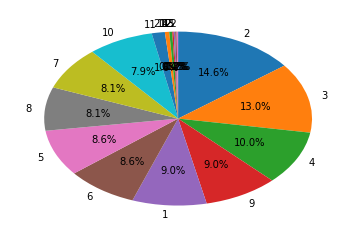

In [220]:
# Nページに表示される項目をカウント
page_num_counts = add_page_num.page_num.value_counts().to_dict()
plt.pie(
    np.array([v for _, v in page_num_counts.items()]),
    counterclock=False,
    startangle=90,
    autopct="%1.1f%%",
    labels=[k for k, _ in page_num_counts.items()],
)
plt.show()

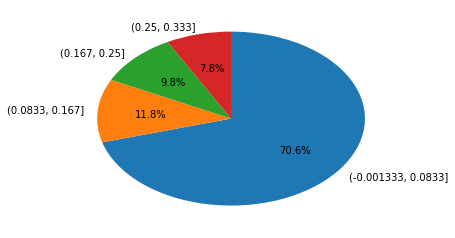

In [221]:
# bins=4(色々と試して4がいい感じに見えるので結果的に4でfix)で度数分布を確認
frequency = display_on_one_page.float_ctr.value_counts(bins=4)

# 各度数分布の割合を確認
ctr_rate = [n / sum(frequency) for n in frequency]
plt.pie(
    np.array(ctr_rate), 
    labels= [k for k, v in frequency.to_dict().items()],
    counterclock=False,
    startangle=90,
    autopct="%1.1f%%",
)
plt.show()

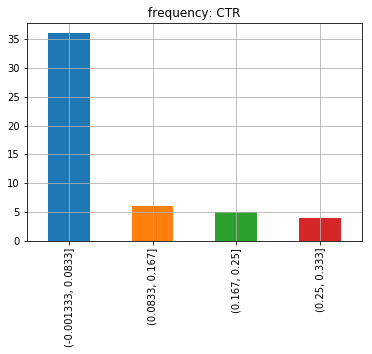

In [158]:
# CTRの度数分布を可視化
frequency.plot(kind="bar", title="frequency: CTR", grid=True)

## CTRの分布より
- トップページに表示されるキーワードの組み合わせのうち、クリックされうる可能性が10%を超えるのは全体の30%にも満たない
- その上、そもそも１ページ目に表示されるキーワードの組み合わせが全体の9%程度